# LIBRARY

In [ ]:
from keras.layers import Dense, Input
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.python.keras.layers import Dense, Dropout, Embedding, Activation
from tensorflow.python.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow.python.keras.backend as K
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from numpy import mean
from numpy import absolute
from numpy import sqrt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

# FUNCTION

In [ ]:
def root_mean_squared_error(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true)))
  
# The function checks the number of elements whose predicted price differs from the real price by more than 1 billion
def find_prediction_error_value(actual, predict):
  error = []
  negative_integer = []
  for i in range(len(predict)):
    if predict[i] < 0:
      negative_integer.append(actual.index[i])
    if abs(predict[i] - actual.iloc[i]) > 1:
      error.append(actual.index[i])
  return error, negative_integer

def assign_negative_predictive_value(predict):
  for i in range(len(predict)):
    if predict[i] < 0:
      predict[i] = 0
  return predict

# DATASET

In [ ]:
data = pd.read_csv('./data/final_data_street_price_update.csv')

In [ ]:
data.head(3)

,size,width,length,room,area,ward,toilet,floor,house type,street,price
0,44.0,3.5,12.0,2.0,102,9466.0,2.0,1.0,3.0,501,3750000000
1,44.8,3.2,14.0,2.0,104,9256.0,2.0,1.0,3.0,1822,890000000
2,50.0,4.4,10.6,3.0,113,9317.0,2.0,2.0,3.0,402,3000000000


# K-FOLD CROSS VALIDATION

In [ ]:
cv = KFold(n_splits=20, random_state=1, shuffle=True)

# NORMALIZE
Chia tỷ lệ dữ liệu trong khoảng từ -1 đến 1

In [ ]:
# data["price"] = np.log(data["price"])
# 1 billion
one_billion = 1000000000
data["price"] = data["price"]/one_billion
X = data.drop("price", axis=1)
y = data["price"]
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(X)
X = pd.DataFrame(columns=X.columns, data=feature_minmax_transform_data)
X.head()

,size,width,length,room,area,ward,toilet,floor,house type,street
0,0.168889,0.30,0.322581,0.142857,0.250000,0.790476,0.142857,0.00,0.666667,0.271104
1,0.172444,0.24,0.387097,0.142857,0.333333,0.123810,0.142857,0.00,0.666667,0.985931
2,0.195556,0.48,0.277419,0.285714,0.708333,0.317460,0.142857,0.25,0.666667,0.217532
3,0.100000,0.20,0.241935,0.142857,0.583333,0.165079,0.142857,0.25,0.666667,0.571429
4,0.231111,0.60,0.354839,0.000000,0.500000,0.777778,0.000000,0.00,0.666667,0.393939


# TRAIN TEST SPLIT

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 8)

In [ ]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (28618, 10)
y_train shape: (28618,)
X_test shape: (12720, 10)
y_test shape: (12720,)
X_val shape: (9540, 10)
y_val shape: (9540,)


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
X_vl_t = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

X_train_CNN = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_CNN = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test_CNN = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# MODEL

In [ ]:
labels_kfold = ['LSTM', 'Linear', 'Ridge', 'Lasso', 'Polynomial', 'Bayesian Linear','CNN']
labels = ['Linear', 'Ridge', 'Lasso', 'Polynomial', 'Bayesian Linear']
compa_n_mse = []
compa_n_mae = []
compa_n_rmse = []
compa_n_r2 = []
compa_k_mse = []
compa_k_mae = []
compa_k_rmse = []
compa_k_r2 = []

## LSTM

### Model structure

In [ ]:
K.clear_session()
model_1 = Sequential()

model_1.add(LSTM(128, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(64, activation='tanh', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(32, activation='relu', return_sequences=True))
model_1.add(Dropout(0.3))

model_1.add(LSTM(16, activation='relu'))
model_1.add(Dropout(0.3))

model_1.add(Dense(1))
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 128)            71168     
_________________________________________________________________
dropout (Dropout)            (None, 1, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 32)             12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3

### MSE

In [ ]:
model_1.compile(loss='mean_squared_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_1 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 36s 142ms/step - loss: 24.4419 - val_loss: 7.0509
Epoch 2/400
112/112 [==============================] - 12s 108ms/step - loss: 8.9981 - val_loss: 5.0292
Epoch 3/400
112/112 [==============================] - 13s 115ms/step - loss: 7.4990 - val_loss: 4.7704
Epoch 4/400
112/112 [==============================] - 11s 101ms/step - loss: 7.2889 - val_loss: 4.7717
Epoch 5/400
112/112 [==============================] - 5s 48ms/step - loss: 6.9754 - val_loss: 4.4926
Epoch 6/400
112/112 [==============================] - 4s 33ms/step - loss: 6.6568 - val_loss: 4.2341
Epoch 7/400
112/112 [==============================] - 4s 33ms/step - loss: 6.4423 - val_loss: 4.0020
Epoch 8/400
112/112 [==============================] - 6s 52ms/step - loss: 6.3400 - val_loss: 3.8321
Epoch 9/400
112/112 [==============================] - 4s 33ms/step - loss: 6.1871 - val_loss: 3.6527
Epoch 10/400
112/112 [==============================] - 4s 34ms/step - lo

#### Loss graph

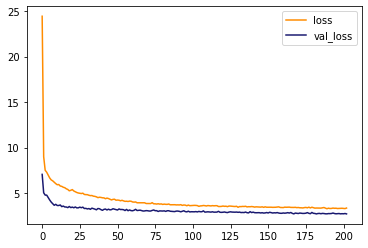

In [ ]:
loss_df_1 = pd.DataFrame(losses_1.history)
loss_df_1.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mse = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_1 = model_1.predict(X_tst_t)

12720/12720 [==============================] - 45s 3ms/step - loss: 2.6679


In [ ]:
compa_k_mse.append(score_mse)

In [ ]:
print('mse: %f'%score_mse)

mse: 2.667930


In [ ]:
print(f"predicted response:\n{y_pred_lstm_1[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.65538120e+09]
 [4.69768620e+09]
 [6.40358114e+09]
 [6.80787945e+09]
 [3.66643143e+09]
 [7.46160603e+09]
 [3.39092064e+09]
 [8.44678783e+09]
 [6.21729374e+09]
 [8.04172707e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_1)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  56.973270440251575


### MAE

In [ ]:
model_1.compile(loss='mean_absolute_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_2 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 12s 39ms/step - loss: 1.2967 - val_loss: 1.1733
Epoch 2/400
112/112 [==============================] - 4s 31ms/step - loss: 1.3021 - val_loss: 1.1579
Epoch 3/400
112/112 [==============================] - 4s 31ms/step - loss: 1.2938 - val_loss: 1.1662
Epoch 4/400
112/112 [==============================] - 4s 31ms/step - loss: 1.2885 - val_loss: 1.1602
Epoch 5/400
112/112 [==============================] - 4s 32ms/step - loss: 1.2923 - val_loss: 1.1519
Epoch 6/400
112/112 [==============================] - 4s 31ms/step - loss: 1.2831 - val_loss: 1.1629
Epoch 7/400
112/112 [==============================] - 3s 31ms/step - loss: 1.2874 - val_loss: 1.1566
Epoch 8/400
112/112 [==============================] - 3s 31ms/step - loss: 1.2810 - val_loss: 1.1585
Epoch 9/400
112/112 [==============================] - 3s 30ms/step - loss: 1.2847 - val_loss: 1.1479
Epoch 10/400
112/112 [==============================] - 3s 30ms/step - loss: 1.28

#### Loss graph

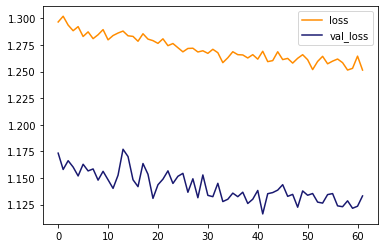

In [ ]:
loss_df_2 = pd.DataFrame(losses_2.history)
loss_df_2.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mae = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_2 = model_1.predict(X_tst_t)

12720/12720 [==============================] - 45s 3ms/step - loss: 1.1249


In [ ]:
compa_k_mae.append(score_mae)

In [ ]:
print('mae: %f'%score_mae)

mae: 1.124882


In [ ]:
print(f"predicted response:\n{y_pred_lstm_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.68244314e+09]
 [5.05136490e+09]
 [6.26159191e+09]
 [6.31516552e+09]
 [3.75456333e+09]
 [7.65987730e+09]
 [3.55444193e+09]
 [7.86236191e+09]
 [6.30932140e+09]
 [8.00259590e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  60.34591194968554


### RMSE

In [ ]:
model_1.compile(loss=root_mean_squared_error, optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_3 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 13s 39ms/step - loss: 1.7998 - val_loss: 1.6121
Epoch 2/400
112/112 [==============================] - 4s 32ms/step - loss: 1.7822 - val_loss: 1.6109
Epoch 3/400
112/112 [==============================] - 4s 33ms/step - loss: 1.7909 - val_loss: 1.6243
Epoch 4/400
112/112 [==============================] - 3s 31ms/step - loss: 1.7928 - val_loss: 1.6107
Epoch 5/400
112/112 [==============================] - 3s 30ms/step - loss: 1.7851 - val_loss: 1.6103
Epoch 6/400
112/112 [==============================] - 3s 31ms/step - loss: 1.7888 - val_loss: 1.6209
Epoch 7/400
112/112 [==============================] - 4s 32ms/step - loss: 1.7970 - val_loss: 1.6099
Epoch 8/400
112/112 [==============================] - 4s 33ms/step - loss: 1.7957 - val_loss: 1.6156
Epoch 9/400
112/112 [==============================] - 4s 32ms/step - loss: 1.7886 - val_loss: 1.6134
Epoch 10/400
112/112 [==============================] - 4s 32ms/step - loss: 1.78

#### Loss graph

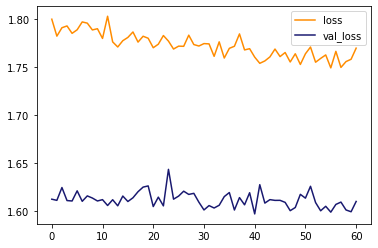

In [ ]:
loss_df_3 = pd.DataFrame(losses_3.history)
loss_df_3.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_rmse = model_1.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_3 = model_1.predict(X_tst_t)

12720/12720 [==============================] - 45s 3ms/step - loss: 1.1360


In [ ]:
compa_k_rmse.append(score_rmse)

In [ ]:
print('rmse: %f'%score_rmse)

rmse: 1.135998


In [ ]:
print(f"predicted response:\n{y_pred_lstm_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.82254124e+09]
 [5.03486776e+09]
 [6.54727602e+09]
 [6.16831017e+09]
 [3.87263870e+09]
 [8.39602852e+09]
 [3.77947664e+09]
 [8.52560806e+09]
 [6.69844961e+09]
 [8.03972912e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  57.7437106918239


### R2

In [ ]:
model_1.compile(loss='mean_squared_error', optimizer='adam')
# Training sẽ dừng khi "val_loss" không giảm (mode='min') sau 10 epochs(patience=10)
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_5 = model_1.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 12s 40ms/step - loss: 3.0898 - val_loss: 2.5739
Epoch 2/400
112/112 [==============================] - 4s 32ms/step - loss: 3.1186 - val_loss: 2.5700
Epoch 3/400
112/112 [==============================] - 4s 33ms/step - loss: 3.0972 - val_loss: 2.5841
Epoch 4/400
112/112 [==============================] - 4s 32ms/step - loss: 3.0710 - val_loss: 2.6067
Epoch 5/400
112/112 [==============================] - 4s 32ms/step - loss: 3.0671 - val_loss: 2.5633
Epoch 6/400
112/112 [==============================] - 4s 31ms/step - loss: 3.0890 - val_loss: 2.5833
Epoch 7/400
112/112 [==============================] - 4s 32ms/step - loss: 3.1362 - val_loss: 2.5819
Epoch 8/400
112/112 [==============================] - 4s 33ms/step - loss: 3.1097 - val_loss: 2.6082
Epoch 9/400
112/112 [==============================] - 4s 33ms/step - loss: 3.1222 - val_loss: 2.5794
Epoch 10/400
112/112 [==============================] - 4s 33ms/step - loss: 3.09

#### r2 values

In [ ]:
y_pred_lstm_5 = model_1.predict(X_tst_t)
score_r2 = r2_score(y_test, y_pred_lstm_5)

In [ ]:
compa_k_r2.append(score_r2)

In [ ]:
print('r2: %f'%score_r2)

r2: 0.741186


## Linear regression

In [ ]:
model_2 = LinearRegression()

### K-Fold

In [ ]:
scores_2_mse = mean(absolute(cross_val_score(model_2, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_2_mae = mean(absolute(cross_val_score(model_2, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_2_rmse = sqrt(mean(absolute(scores_2_mse)))
scores_2_r2 = mean(absolute(cross_val_score(model_2, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_2.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred_2 = model_2.predict(X_test)
y_pred_2 = assign_negative_predictive_value(y_pred_2)
# Sai số huấn luyện của mô hình trên tập train
print(model_2.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_2.coef_)
print(model_2.intercept_)

0.5417007589136671
[ 6.94604646  1.24004537  4.59443603  0.03310608 -1.90414743 -1.7304305
  2.41432572  2.9419431  -1.03363562 -0.28748784]
2.270142878779097


In [ ]:
print(f"predicted response:\n{y_pred_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.03701733e+09 6.34470224e+09 5.44407244e+09 6.97385392e+09
 3.38232033e+09 6.03816153e+09 2.41904647e+09 7.17222506e+09
 8.05758752e+09 5.93944598e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_2))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_2))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_2)))
compa_n_r2.append(r2_score(y_test, y_pred_2))
compa_k_mse.append(scores_2_mse)
compa_k_mae.append(scores_2_mae)
compa_k_rmse.append(scores_2_rmse)
compa_k_r2.append(scores_2_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_2)}")
print(f"mse (K-fold):\n{scores_2_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_2)}")
print(f"mae (K-fold):\n{scores_2_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_2))}")
print(f"rmse (K-fold):\n{scores_2_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_2)}")
print(f"r2 (K-fold):\n{scores_2_r2}")

mse:
4.467682067153811
mse (K-fold):
4.552014520467494
mae:
1.5599390356075153
mae (K-fold):
1.5675303908191478
rmse:
2.113689207796125
rmse (K-fold):
2.1335450593946907
r2:
0.5404438710795993
r2 (K-fold):
0.5426363157599838


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  43.789308176100626


## Ridge regression

In [ ]:
model_3 = Ridge(alpha = 0.3,  tol = 0.003, solver ='auto', random_state = 42)

### K-Fold

In [ ]:
scores_3_mse = mean(absolute(cross_val_score(model_3, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_3_mae = mean(absolute(cross_val_score(model_3, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_3_rmse = sqrt(mean(absolute(scores_3_mse)))
scores_3_r2 = mean(absolute(cross_val_score(model_3, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
# training model with alpha = 0.5

model_3.fit(X_train, y_train)

y_pred_3 = model_3.predict(X_test)
y_pred_3 = assign_negative_predictive_value(y_pred_3)

# Sai số huấn luyện của mô hình trên tập train
print(model_3.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_3.coef_)
print(model_3.intercept_)

0.5417004377908826
[ 6.86816544  1.26218002  4.63929428  0.03541357 -1.90348815 -1.73001456
  2.41292921  2.94083892 -1.03395195 -0.28748922]
2.2611362537472814


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_3))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_3))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_3)))
compa_n_r2.append(r2_score(y_test, y_pred_3))
compa_k_mse.append(scores_3_mse)
compa_k_mae.append(scores_3_mae)
compa_k_rmse.append(scores_3_rmse)
compa_k_r2.append(scores_3_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_3)}")
print(f"mse (K-fold):\n{scores_3_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_3)}")
print(f"mae (K-fold):\n{scores_3_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_3))}")
print(f"rmse (K-fold):\n{scores_3_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_3)}")
print(f"r2 (K-fold):\n{scores_3_r2}")

mse:
4.467686521651408
mse (K-fold):
4.552009463879321
mae:
1.5599132163230456
mae (K-fold):
1.567519038907501
rmse:
2.1136902615216373
rmse (K-fold):
2.1335438743741175
r2:
0.5404434128796557
r2 (K-fold):
0.5426368556380845


In [ ]:
print(f"predicted response:\n{y_pred_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.03746408e+09 6.34271460e+09 5.44454677e+09 6.97351569e+09
 3.38211585e+09 6.03821194e+09 2.41756396e+09 7.17342579e+09
 8.05523360e+09 5.93970305e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  43.765723270440255


## Lasso regression

In [ ]:
model_4 = Lasso(alpha=0.3)

### K-Fold

In [ ]:
scores_4_mse = mean(absolute(cross_val_score(model_4, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_4_mae = mean(absolute(cross_val_score(model_4, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_4_rmse = sqrt(mean(absolute(scores_4_mse)))
scores_4_r2 = mean(absolute(cross_val_score(model_4, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_4.fit(X_train, y_train)

y_pred_4 = model_4.predict(X_test)
y_pred_4 = assign_negative_predictive_value(y_pred_4)
# Sai số huấn luyện của mô hình trên tập train
print(model_4.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_4.coef_)
print(model_4.intercept_)

0.06619229549801109
[ 0.          0.          0.          0.         -0.         -0.
  0.          0.98568802 -0.         -0.        ]
5.005521910143378


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_4))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_4))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_4)))
compa_n_r2.append(r2_score(y_test, y_pred_4))
compa_k_mse.append(scores_4_mse)
compa_k_mae.append(scores_4_mae)
compa_k_rmse.append(scores_4_rmse)
compa_k_r2.append(scores_4_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_4)}")
print(f"mse (K-fold):\n{scores_4_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_4)}")
print(f"mae (K-fold):\n{scores_4_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_4))}")
print(f"rmse (K-fold):\n{scores_4_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_4)}")
print(f"r2 (K-fold):\n{scores_4_r2}")

mse:
9.071568618646282
mse (K-fold):
9.324592121639643
mae:
2.284681583918462
mae (K-fold):
2.3092837785629188
rmse:
3.0119044836525415
rmse (K-fold):
3.053619511602525
r2:
0.06687743331818752
r2 (K-fold):
0.06335520287085998


In [ ]:
print(f"predicted response:\n{y_pred_4[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[5.49836592e+09 5.00552191e+09 5.49836592e+09 5.25194392e+09
 5.25194392e+09 5.49836592e+09 5.00552191e+09 5.49836592e+09
 5.25194392e+09 5.25194392e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_4)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  28.67138364779874


## Polynomial regression

In [ ]:
model_5 = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])

### K-Fold

In [ ]:
scores_5_mse = mean(absolute(cross_val_score(model_5, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_5_mae = mean(absolute(cross_val_score(model_5, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_5_rmse = sqrt(mean(absolute(scores_5_mse)))
scores_5_r2 = mean(absolute(cross_val_score(model_5, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_5.fit(X_train, y_train)
y_pred_5 = model_5.predict(X_test)
y_pred_5 = assign_negative_predictive_value(y_pred_5)
# Sai số huấn luyện của mô hình trên tập train
print(model_5.score(X_train, y_train))

0.7121968025816161


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_5))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_5))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_5)))
compa_n_r2.append(r2_score(y_test, y_pred_5))
compa_k_mse.append(scores_5_mse)
compa_k_mae.append(scores_5_mae)
compa_k_rmse.append(scores_5_rmse)
compa_k_r2.append(scores_5_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_5)}")
print(f"mse (K-fold):\n{scores_5_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_5)}")
print(f"mae (K-fold):\n{scores_5_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_5))}")
print(f"rmse (K-fold):\n{scores_5_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_5)}")
print(f"r2 (K-fold):\n{scores_5_r2}")

mse:
2.8805500981716237
mse (K-fold):
2.954810893808507
mae:
1.2000938155544876
mae (K-fold):
1.205676216004035
rmse:
1.697218341337267
rmse (K-fold):
1.718956338540484
r2:
0.7036999427489796
r2 (K-fold):
0.7031374132530992


In [ ]:
print(f"predicted response:\n{y_pred_5[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.01947744e+09 4.78398940e+09 6.80659814e+09 6.33161666e+09
 3.79748399e+09 7.55223325e+09 3.49569768e+09 8.41968331e+09
 6.62204988e+09 8.00491907e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_5)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  56.91823899371069


## Bayesian linear regression

In [ ]:
model_6 = BayesianRidge()

### K-Fold

In [ ]:
scores_6_mse = mean(absolute(cross_val_score(model_6, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_6_mae = mean(absolute(cross_val_score(model_6, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_6_rmse = sqrt(mean(absolute(scores_6_mse)))
scores_6_r2 = mean(absolute(cross_val_score(model_6, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_6.fit(X_train, y_train)
y_pred_6 = model_6.predict(X_test)
y_pred_6 = assign_negative_predictive_value(y_pred_6)
# Sai số huấn luyện của mô hình trên tập train
print(model_6.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_6.coef_)
print(model_6.intercept_)

0.5416999115192391
[ 6.8197071   1.27593454  4.6671044   0.03693317 -1.90305746 -1.72975315
  2.41202316  2.94012807 -1.03415942 -0.2874888 ]
2.255564299730125


### Loss values

In [ ]:
compa_n_mse.append(mean_squared_error(y_test, y_pred_6))
compa_n_mae.append(mean_absolute_error(y_test, y_pred_6))
compa_n_rmse.append(sqrt(mean_squared_error(y_test, y_pred_6)))
compa_n_r2.append(r2_score(y_test, y_pred_6))
compa_k_mse.append(scores_6_mse)
compa_k_mae.append(scores_6_mae)
compa_k_rmse.append(scores_6_rmse)
compa_k_r2.append(scores_6_r2)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_6)}")
print(f"mse (K-fold):\n{scores_6_mse}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_6)}")
print(f"mae (K-fold):\n{scores_6_mae}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_6))}")
print(f"rmse (K-fold):\n{scores_6_rmse}")
print(f"r2:\n{r2_score(y_test, y_pred_6)}")
print(f"r2 (K-fold):\n{scores_6_r2}")

mse:
4.467693249478583
mse (K-fold):
4.552010568731281
mae:
1.5598968592101532
mae (K-fold):
1.567512881316243
rmse:
2.1136918530094646
rmse (K-fold):
2.133544133298227
r2:
0.5404427208397643
r2 (K-fold):
0.5426367605055474


In [ ]:
print(f"predicted response:\n{y_pred_6[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.03773341e+09 6.34145886e+09 5.44485009e+09 6.97329516e+09
 3.38198981e+09 6.03824413e+09 2.41665854e+09 7.17416070e+09
 8.05374019e+09 5.93986959e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_6)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  43.75


## CNN

### Model structure

In [ ]:
K.clear_session()
model_7 = Sequential()

model_7.add(Conv1D(32, 2, activation="relu", input_shape=(X_train.shape[1],1)))
model_7.add(Conv1D(64, 2, activation="relu"))
model_7.add(Flatten())
model_7.add(Dense(128, activation="relu"))
model_7.add(Dense(1))
model_7.compile(loss="mse", optimizer="adam")
model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9, 32)             96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 70,049
Trainable params: 70,049
Non-trainable params: 0
_________________________________________________________________


### MSE

In [ ]:
model_7.compile(loss="mse", optimizer="adam")
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_cnn_1 = model_7.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 10s 6ms/step - loss: 10.0072 - val_loss: 4.9890
Epoch 2/400
112/112 [==============================] - 0s 4ms/step - loss: 4.6135 - val_loss: 4.2872
Epoch 3/400
112/112 [==============================] - 0s 4ms/step - loss: 4.1621 - val_loss: 3.8637
Epoch 4/400
112/112 [==============================] - 0s 4ms/step - loss: 3.6869 - val_loss: 3.4973
Epoch 5/400
112/112 [==============================] - 0s 4ms/step - loss: 3.4296 - val_loss: 3.3449
Epoch 6/400
112/112 [==============================] - 0s 4ms/step - loss: 3.2984 - val_loss: 3.2858
Epoch 7/400
112/112 [==============================] - 0s 4ms/step - loss: 3.2488 - val_loss: 3.2088
Epoch 8/400
112/112 [==============================] - 0s 4ms/step - loss: 3.1847 - val_loss: 3.1390
Epoch 9/400
112/112 [==============================] - 0s 3ms/step - loss: 3.1335 - val_loss: 3.0922
Epoch 10/400
112/112 [==============================] - 0s 4ms/step - loss: 3.0600 - val_

#### Loss graph

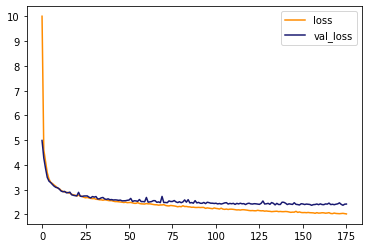

In [ ]:
loss_df_4 = pd.DataFrame(losses_cnn_1.history)
loss_df_4.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_cnn_mse = model_7.evaluate(X_test_CNN, y_test, batch_size=1)
y_pred_cnn_1 = model_7.predict(X_test_CNN)
y_pred_cnn_1 = assign_negative_predictive_value(y_pred_cnn_1)

12720/12720 [==============================] - 24s 2ms/step - loss: 2.2893


In [ ]:
compa_k_mse.append(score_cnn_mse)

In [ ]:
print('mse: %f'%score_cnn_mse)

mse: 2.289260


In [ ]:
print(f"predicted response:\n{y_pred_cnn_1[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.84074640e+09]
 [4.13600206e+09]
 [6.48410559e+09]
 [4.76123476e+09]
 [3.36802721e+09]
 [9.72060394e+09]
 [3.56757689e+09]
 [8.39992809e+09]
 [5.69326925e+09]
 [7.23493242e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_cnn_1)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  63.223270440251575


### MAE

In [ ]:
model_7.compile(loss="mean_absolute_error", optimizer="adam")
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_cnn_2 = model_7.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 1s 5ms/step - loss: 0.9961 - val_loss: 1.0587
Epoch 2/400
112/112 [==============================] - 0s 4ms/step - loss: 0.9921 - val_loss: 1.0657
Epoch 3/400
112/112 [==============================] - 0s 4ms/step - loss: 0.9913 - val_loss: 1.0643
Epoch 4/400
112/112 [==============================] - 0s 3ms/step - loss: 0.9892 - val_loss: 1.0626
Epoch 5/400
112/112 [==============================] - 0s 4ms/step - loss: 0.9907 - val_loss: 1.0546
Epoch 6/400
112/112 [==============================] - 0s 4ms/step - loss: 0.9887 - val_loss: 1.0552
Epoch 7/400
112/112 [==============================] - 0s 3ms/step - loss: 0.9884 - val_loss: 1.0676
Epoch 8/400
112/112 [==============================] - 0s 4ms/step - loss: 0.9847 - val_loss: 1.0561
Epoch 9/400
112/112 [==============================] - 0s 3ms/step - loss: 0.9825 - val_loss: 1.0605
Epoch 10/400
112/112 [==============================] - 0s 3ms/step - loss: 0.9826 - val_lo

#### Loss graph

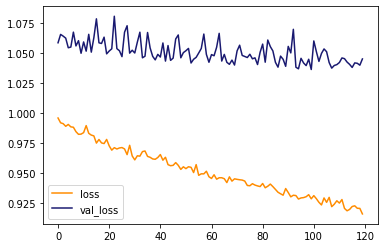

In [ ]:
loss_df_5 = pd.DataFrame(losses_cnn_2.history)
loss_df_5.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss value

In [ ]:
score_cnn_mae = model_7.evaluate(X_test_CNN, y_test, batch_size=1)
y_pred_cnn_2 = model_7.predict(X_test_CNN)
y_pred_cnn_2 = assign_negative_predictive_value(y_pred_cnn_2)

12720/12720 [==============================] - 24s 2ms/step - loss: 1.0159


In [ ]:
compa_k_mae.append(score_cnn_mae)

In [ ]:
print('mae: %f'%score_cnn_mae)

mae: 1.015929


In [ ]:
print(f"predicted response:\n{y_pred_cnn_2[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.61524105e+09]
 [5.30160427e+09]
 [6.41368151e+09]
 [4.30158997e+09]
 [3.76833820e+09]
 [9.25800800e+09]
 [3.53866959e+09]
 [7.85776377e+09]
 [5.29071188e+09]
 [6.87027216e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_cnn_2)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  64.77201257861635


### RMSE

In [ ]:
model_7.compile(loss=root_mean_squared_error, optimizer="adam")
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_cnn_3 = model_7.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 1s 5ms/step - loss: 1.3758 - val_loss: 1.5463
Epoch 2/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3621 - val_loss: 1.5459
Epoch 3/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3647 - val_loss: 1.5470
Epoch 4/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3693 - val_loss: 1.5493
Epoch 5/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3570 - val_loss: 1.5456
Epoch 6/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3570 - val_loss: 1.5422
Epoch 7/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3543 - val_loss: 1.5414
Epoch 8/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3561 - val_loss: 1.5373
Epoch 9/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3486 - val_loss: 1.5497
Epoch 10/400
112/112 [==============================] - 0s 3ms/step - loss: 1.3557 - val_lo

#### Loss graph

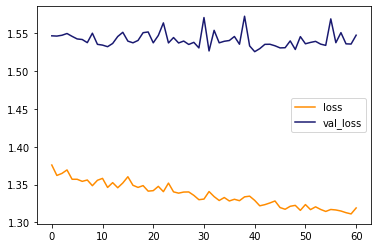

In [ ]:
loss_df_6 = pd.DataFrame(losses_cnn_3.history)
loss_df_6.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_cnn_rmse = model_7.evaluate(X_test_CNN, y_test, batch_size=1)
y_pred_cnn_3 = model_7.predict(X_test_CNN)
y_pred_cnn_3 = assign_negative_predictive_value(y_pred_cnn_3)

12720/12720 [==============================] - 24s 2ms/step - loss: 1.0256


In [ ]:
compa_k_rmse.append(score_cnn_rmse)

In [ ]:
print('rmse: %f'%score_cnn_rmse)

rmse: 1.025605


In [ ]:
print(f"predicted response:\n{y_pred_cnn_3[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.75388241e+09]
 [5.43654251e+09]
 [6.11634493e+09]
 [4.60011578e+09]
 [3.91840935e+09]
 [9.62771034e+09]
 [3.59032202e+09]
 [7.77974558e+09]
 [5.25370455e+09]
 [6.52959633e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_cnn_3)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  64.19025157232704


### R2

In [ ]:
model_7.compile(loss="mse", optimizer="adam")
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)
losses_cnn_4 = model_7.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 1s 5ms/step - loss: 1.7245 - val_loss: 2.3766
Epoch 2/400
112/112 [==============================] - 0s 3ms/step - loss: 1.7285 - val_loss: 2.3931
Epoch 3/400
112/112 [==============================] - 0s 4ms/step - loss: 1.7387 - val_loss: 2.4546
Epoch 4/400
112/112 [==============================] - 0s 4ms/step - loss: 1.7192 - val_loss: 2.4410
Epoch 5/400
112/112 [==============================] - 0s 3ms/step - loss: 1.7345 - val_loss: 2.4029
Epoch 6/400
112/112 [==============================] - 0s 4ms/step - loss: 1.7208 - val_loss: 2.4535
Epoch 7/400
112/112 [==============================] - 0s 3ms/step - loss: 1.7128 - val_loss: 2.4094
Epoch 8/400
112/112 [==============================] - 0s 3ms/step - loss: 1.7035 - val_loss: 2.4297
Epoch 9/400
112/112 [==============================] - 0s 4ms/step - loss: 1.7129 - val_loss: 2.4169
Epoch 10/400
112/112 [==============================] - 0s 3ms/step - loss: 1.7186 - val_lo

#### r2 values

In [ ]:
y_pred_cnn_4 = model_7.predict(X_test_CNN)
y_pred_cnn_4 = assign_negative_predictive_value(y_pred_cnn_4)
score_cnn_r2 = r2_score(y_test, y_pred_cnn_4)

In [ ]:
compa_k_r2.append(score_cnn_r2)

In [ ]:
print('r2: %f'%score_cnn_r2)

r2: 0.772666


# USING GRIDSEARCHCV

In [ ]:
labels_gridSearchCV = ['LSTM', 'Ridge', 'Lasso', 'Polynomial','CNN']
compa_k_mse_gridSearchCV = []
compa_k_mae_gridSearchCV = []
compa_k_rmse_gridSearchCV = []
compa_k_r2_gridSearchCV = []

## LSTM

In [ ]:
def LSTM_Model(dropout_rate=0.3, optimizer='adam', activation='relu', loss='mean_squared_error'):
  K.clear_session()
  model = Sequential()

  model.add(LSTM(128, input_shape=(1, X_train.shape[1]), activation=activation, return_sequences=True))
  model.add(Dropout(dropout_rate))

  model.add(LSTM(64, activation=activation, return_sequences=True))
  model.add(Dropout(dropout_rate))

  model.add(LSTM(32, activation=activation, return_sequences=True))
  model.add(Dropout(dropout_rate))

  model.add(LSTM(16, activation=activation))
  model.add(Dropout(dropout_rate))

  model.add(Dense(1))
  model.compile(loss=loss, optimizer=optimizer)
  return model

In [ ]:
dropout_rate = [0.1,0.2,0.3,0.4,0.5]
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)

grid_param = {'batch_size': [256],
    'optimizer': ['Nadam', 'Adam', 'RMSProp','SGD'],
    'activation': ['relu','sigmoid','hard_sigmoid','tanh','softmax'],
    'dropout_rate':dropout_rate,
    'callbacks':[earlyStop]}

model_LSTM=KerasRegressor(build_fn=LSTM_Model)

grid = GridSearchCV(estimator=model_LSTM,param_grid=grid_param,refit=True,verbose=3,cv=2)

grid.fit(X_tr_t, y_train)

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
56/56 [==============================] - 1s 4ms/step - loss: 9.5907
[CV 1/2] END activation=relu, batch_size=256, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff8e9a4fd0>, dropout_rate=0.1, optimizer=Nadam;, score=-9.591 total time=  12.0s
56/56 [==============================] - 1s 4ms/step - loss: 9.3050
[CV 2/2] END activation=relu, batch_size=256, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff8e9a4fd0>, dropout_rate=0.1, optimizer=Nadam;, score=-9.305 total time=  13.0s
56/56 [==============================] - 1s 4ms/step - loss: 24.0712
[CV 1/2] END activation=relu, batch_size=256, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff8e9a4fd0>, dropout_rate=0.1, optimizer=Adam;, score=-24.071 total time=  10.9s
56/56 [==============================] - 1s 4ms/step - loss: 33.4303
[CV 2/2] END activation=relu, batch_size=256, callbacks=<tensor

### MSE

In [ ]:
model_1_gridSearchCV = LSTM_Model(dropout_rate=grid.best_params_['dropout_rate'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss='mean_squared_error')
losses_1_gridSearchCV = model_1_gridSearchCV.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 14s 46ms/step - loss: 19.4623 - val_loss: 6.7024
Epoch 2/400
112/112 [==============================] - 4s 33ms/step - loss: 6.3799 - val_loss: 4.8642
Epoch 3/400
112/112 [==============================] - 4s 33ms/step - loss: 5.5239 - val_loss: 4.5854
Epoch 4/400
112/112 [==============================] - 4s 34ms/step - loss: 5.2683 - val_loss: 4.5548
Epoch 5/400
112/112 [==============================] - 4s 34ms/step - loss: 5.2880 - val_loss: 4.4444
Epoch 6/400
112/112 [==============================] - 4s 34ms/step - loss: 5.1850 - val_loss: 4.3902
Epoch 7/400
112/112 [==============================] - 4s 34ms/step - loss: 5.0670 - val_loss: 4.1957
Epoch 8/400
112/112 [==============================] - 4s 34ms/step - loss: 4.9627 - val_loss: 4.2041
Epoch 9/400
112/112 [==============================] - 4s 33ms/step - loss: 4.9288 - val_loss: 4.1231
Epoch 10/400
112/112 [==============================] - 4s 33ms/step - loss: 4.8

#### Loss graph

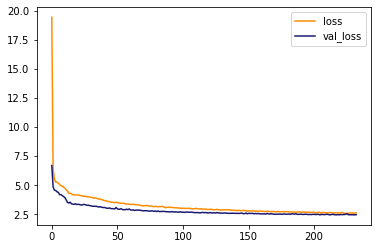

In [ ]:
loss_df_1_gridSearchCV = pd.DataFrame(losses_1_gridSearchCV.history)
loss_df_1_gridSearchCV.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mse_gridSearchCV = model_1_gridSearchCV.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_1_gridSearchCV = model_1_gridSearchCV.predict(X_tst_t)

12720/12720 [==============================] - 46s 4ms/step - loss: 2.3932


In [ ]:
compa_k_mse_gridSearchCV.append(score_mse_gridSearchCV)

In [ ]:
print('mse: %f'%score_mse_gridSearchCV)

mse: 2.393172


In [ ]:
print(f"predicted response:\n{y_pred_1_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.57332325e+09]
 [4.84189320e+09]
 [6.49532175e+09]
 [5.87852192e+09]
 [3.35980368e+09]
 [8.39985180e+09]
 [3.64164042e+09]
 [8.64675140e+09]
 [6.42385626e+09]
 [7.67348385e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_1_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  62.11477987421383


### MAE

In [ ]:
model_1_gridSearchCV = LSTM_Model(dropout_rate=grid.best_params_['dropout_rate'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss='mean_absolute_error')
losses_2_gridSearchCV = model_1_gridSearchCV.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 13s 40ms/step - loss: 3.2387 - val_loss: 1.7446
Epoch 2/400
112/112 [==============================] - 4s 33ms/step - loss: 1.7671 - val_loss: 1.5634
Epoch 3/400
112/112 [==============================] - 4s 32ms/step - loss: 1.6882 - val_loss: 1.5336
Epoch 4/400
112/112 [==============================] - 4s 32ms/step - loss: 1.6509 - val_loss: 1.5051
Epoch 5/400
112/112 [==============================] - 4s 33ms/step - loss: 1.6175 - val_loss: 1.4849
Epoch 6/400
112/112 [==============================] - 4s 33ms/step - loss: 1.5904 - val_loss: 1.4493
Epoch 7/400
112/112 [==============================] - 4s 32ms/step - loss: 1.5675 - val_loss: 1.4080
Epoch 8/400
112/112 [==============================] - 4s 33ms/step - loss: 1.5477 - val_loss: 1.3870
Epoch 9/400
112/112 [==============================] - 4s 33ms/step - loss: 1.5367 - val_loss: 1.3739
Epoch 10/400
112/112 [==============================] - 4s 32ms/step - loss: 1.51

#### Loss graph

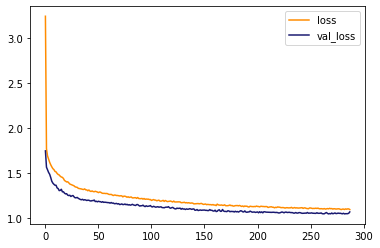

In [ ]:
loss_df_2_gridSearchCV = pd.DataFrame(losses_2_gridSearchCV.history)
loss_df_2_gridSearchCV.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_mae_gridSearchCV = model_1_gridSearchCV.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_2_gridSearchCV = model_1_gridSearchCV.predict(X_tst_t)

12720/12720 [==============================] - 45s 3ms/step - loss: 1.0418


In [ ]:
compa_k_mae_gridSearchCV.append(score_mae_gridSearchCV)

In [ ]:
print('mae: %f'%score_mae_gridSearchCV)

mae: 1.041794


In [ ]:
print(f"predicted response:\n{y_pred_lstm_2_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.71698761e+09]
 [5.51208019e+09]
 [6.09875488e+09]
 [5.70509005e+09]
 [3.70893335e+09]
 [8.01320457e+09]
 [3.58633065e+09]
 [7.73123932e+09]
 [5.29993439e+09]
 [7.40925121e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_2_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  64.7877358490566


### RMSE

In [ ]:
model_1_gridSearchCV = LSTM_Model(dropout_rate=grid.best_params_['dropout_rate'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss=root_mean_squared_error)
losses_3_gridSearchCV = model_1_gridSearchCV.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 14s 40ms/step - loss: 4.0317 - val_loss: 2.3712
Epoch 2/400
112/112 [==============================] - 4s 32ms/step - loss: 2.4360 - val_loss: 2.1427
Epoch 3/400
112/112 [==============================] - 4s 32ms/step - loss: 2.3126 - val_loss: 2.0909
Epoch 4/400
112/112 [==============================] - 4s 32ms/step - loss: 2.2389 - val_loss: 2.0339
Epoch 5/400
112/112 [==============================] - 4s 33ms/step - loss: 2.1889 - val_loss: 1.9511
Epoch 6/400
112/112 [==============================] - 4s 33ms/step - loss: 2.1285 - val_loss: 1.9324
Epoch 7/400
112/112 [==============================] - 4s 32ms/step - loss: 2.1218 - val_loss: 1.8891
Epoch 8/400
112/112 [==============================] - 4s 33ms/step - loss: 2.0883 - val_loss: 1.8754
Epoch 9/400
112/112 [==============================] - 4s 32ms/step - loss: 2.0663 - val_loss: 1.8597
Epoch 10/400
112/112 [==============================] - 4s 32ms/step - loss: 2.05

#### Loss graph

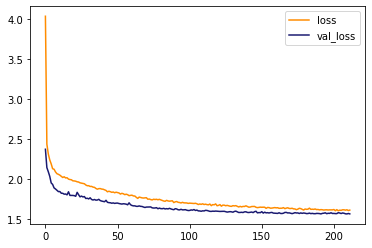

In [ ]:
loss_df_3_gridSearchCV = pd.DataFrame(losses_3_gridSearchCV.history)
loss_df_3_gridSearchCV.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_rmse_gridSearchCV = model_1_gridSearchCV.evaluate(X_tst_t, y_test, batch_size=1)
y_pred_lstm_3_gridSearchCV = model_1_gridSearchCV.predict(X_tst_t)

12720/12720 [==============================] - 44s 3ms/step - loss: 1.0582


In [ ]:
compa_k_rmse_gridSearchCV.append(score_rmse_gridSearchCV)

In [ ]:
print('rmse: %f'%score_rmse_gridSearchCV)

rmse: 1.058180


In [ ]:
print(f"predicted response:\n{y_pred_lstm_3_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.66057777e+09]
 [5.17699242e+09]
 [6.26971912e+09]
 [6.02245092e+09]
 [3.64103436e+09]
 [8.82474709e+09]
 [3.65553784e+09]
 [8.17268181e+09]
 [6.39968061e+09]
 [8.03620815e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_lstm_3_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  62.759433962264154


### R2

In [ ]:
model_1_gridSearchCV = LSTM_Model(dropout_rate=grid.best_params_['dropout_rate'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss='mean_squared_error')
losses_5_gridSearchCV = model_1_gridSearchCV.fit(X_tr_t, y_train, validation_data=(X_vl_t, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 12s 38ms/step - loss: 18.9723 - val_loss: 5.9037
Epoch 2/400
112/112 [==============================] - 3s 31ms/step - loss: 6.0145 - val_loss: 4.6220
Epoch 3/400
112/112 [==============================] - 4s 31ms/step - loss: 5.2628 - val_loss: 4.3347
Epoch 4/400
112/112 [==============================] - 4s 32ms/step - loss: 4.9253 - val_loss: 4.0288
Epoch 5/400
112/112 [==============================] - 4s 33ms/step - loss: 4.6725 - val_loss: 3.7894
Epoch 6/400
112/112 [==============================] - 4s 32ms/step - loss: 4.4384 - val_loss: 3.5941
Epoch 7/400
112/112 [==============================] - 4s 32ms/step - loss: 4.3269 - val_loss: 3.6805
Epoch 8/400
112/112 [==============================] - 4s 34ms/step - loss: 4.3033 - val_loss: 3.4857
Epoch 9/400
112/112 [==============================] - 5s 48ms/step - loss: 4.2047 - val_loss: 3.4169
Epoch 10/400
112/112 [==============================] - 4s 31ms/step - loss: 4.1

#### r2 values

In [ ]:
y_pred_lstm_5_gridSearchCV = model_1_gridSearchCV.predict(X_tst_t)
score_r2_gridSearchCV = r2_score(y_test, y_pred_lstm_5_gridSearchCV)

In [ ]:
compa_k_r2_gridSearchCV.append(score_r2_gridSearchCV)

In [ ]:
print('r2: %f'%score_r2_gridSearchCV)

r2: 0.760083


## Ridge Regression

In [ ]:
alpha = [0.1*(i+1) for i in range(10)]
tol = [0.001*(i+1) for i in range(10)]

# defining parameter range 
param_grid = {'alpha': alpha,  
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
              'tol': tol}  
  
grid = GridSearchCV(Ridge(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END .alpha=0.1, solver=auto, tol=0.001;, score=0.538 total time=   0.0s
[CV 2/5] END .alpha=0.1, solver=auto, tol=0.001;, score=0.545 total time=   0.0s
[CV 3/5] END .alpha=0.1, solver=auto, tol=0.001;, score=0.534 total time=   0.0s
[CV 4/5] END .alpha=0.1, solver=auto, tol=0.001;, score=0.552 total time=   0.0s
[CV 5/5] END .alpha=0.1, solver=auto, tol=0.001;, score=0.536 total time=   0.0s
[CV 1/5] END .alpha=0.1, solver=auto, tol=0.002;, score=0.538 total time=   0.0s
[CV 2/5] END .alpha=0.1, solver=auto, tol=0.002;, score=0.545 total time=   0.0s
[CV 3/5] END .alpha=0.1, solver=auto, tol=0.002;, score=0.534 total time=   0.0s
[CV 4/5] END .alpha=0.1, solver=auto, tol=0.002;, score=0.552 total time=   0.0s
[CV 5/5] END .alpha=0.1, solver=auto, tol=0.002;, score=0.536 total time=   0.0s
[CV 1/5] END .alpha=0.1, solver=auto, tol=0.003;, score=0.538 total time=   0.0s
[CV 2/5] END .alpha=0.1, solver=auto, tol=0.0

In [ ]:
model_3_gridSearchCV = Ridge(alpha = grid.best_params_['alpha'],  tol = grid.best_params_['tol'], solver =grid.best_params_['solver'], random_state = 42)

scores_3_mse_gridSearchCV = mean(absolute(cross_val_score(model_3_gridSearchCV, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_3_mae_gridSearchCV = mean(absolute(cross_val_score(model_3_gridSearchCV, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_3_mape_gridSearchCV = mean(absolute(cross_val_score(model_3_gridSearchCV, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)))
scores_3_rmse_gridSearchCV = sqrt(mean(absolute(scores_3_mse_gridSearchCV)))
scores_3_r2_gridSearchCV = mean(absolute(cross_val_score(model_3_gridSearchCV, X, y, scoring='r2', cv=cv, n_jobs=-1)))

model_3_gridSearchCV.fit(X_train, y_train)

y_pred_3_gridSearchCV = model_3_gridSearchCV.predict(X_test)
y_pred_3_gridSearchCV = assign_negative_predictive_value(y_pred_3_gridSearchCV)
# Sai số huấn luyện của mô hình trên tập train
print(model_3_gridSearchCV.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_3_gridSearchCV.coef_)
print(model_3_gridSearchCV.intercept_)

0.5416976141452939
[ 6.74995977  1.29888868  4.720909    0.04898584 -1.90403645 -1.73162108
  2.40260285  2.94405053 -1.03859984 -0.29206703]
2.2449203619747027


### Loss values

In [ ]:
compa_k_mse_gridSearchCV.append(scores_3_mse_gridSearchCV)
compa_k_mae_gridSearchCV.append(scores_3_mae_gridSearchCV)
compa_k_rmse_gridSearchCV.append(scores_3_rmse_gridSearchCV)
compa_k_r2_gridSearchCV.append(scores_3_r2_gridSearchCV)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_3_gridSearchCV)}")
print(f"mse (K-fold):\n{scores_3_mse_gridSearchCV}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_3_gridSearchCV)}")
print(f"mae (K-fold):\n{scores_3_mae_gridSearchCV}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_3_gridSearchCV))}")
print(f"rmse (K-fold):\n{scores_3_rmse_gridSearchCV}")
print(f"r2:\n{r2_score(y_test, y_pred_3_gridSearchCV)}")
print(f"r2 (K-fold):\n{scores_3_r2_gridSearchCV}")

mse:
4.467750482931121
mse (K-fold):
4.552102258902302
mae:
1.5601707956842854
mae (K-fold):
1.5676419257131573
rmse:
2.1137053917069712
rmse (K-fold):
2.1335656209505958
r2:
0.5404368336742279
r2 (K-fold):
0.5426274282184729


In [ ]:
print(f"predicted response:\n{y_pred_3_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.03808035e+09 6.34069830e+09 5.44514882e+09 6.97214673e+09
 3.37641754e+09 6.03918792e+09 2.40846210e+09 7.17670791e+09
 8.05363194e+09 5.94235720e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_3_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  43.742138364779876


## Lasso Regression

In [ ]:
alpha = [0.1*(i+1) for i in range(10)]

# defining parameter range 
param_grid = {'alpha': alpha}  

grid = GridSearchCV(Lasso(), param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train) 
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .........................alpha=0.1;, score=0.442 total time=   0.0s
[CV 2/5] END .........................alpha=0.1;, score=0.440 total time=   0.0s
[CV 3/5] END .........................alpha=0.1;, score=0.433 total time=   0.0s
[CV 4/5] END .........................alpha=0.1;, score=0.439 total time=   0.0s
[CV 5/5] END .........................alpha=0.1;, score=0.430 total time=   0.0s
[CV 1/5] END .........................alpha=0.2;, score=0.255 total time=   0.0s
[CV 2/5] END .........................alpha=0.2;, score=0.252 total time=   0.0s
[CV 3/5] END .........................alpha=0.2;, score=0.243 total time=   0.0s
[CV 4/5] END .........................alpha=0.2;, score=0.243 total time=   0.0s
[CV 5/5] END .........................alpha=0.2;, score=0.239 total time=   0.0s
[CV 1/5] END .........alpha=0.30000000000000004;, score=0.069 total time=   0.0s
[CV 2/5] END .........alpha=0.30000000000000004;

In [ ]:
model_4_gridSearchCV = Lasso(alpha=grid.best_params_['alpha'])

scores_4_mse_gridSearchCV = mean(absolute(cross_val_score(model_4_gridSearchCV, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_4_mae_gridSearchCV = mean(absolute(cross_val_score(model_4_gridSearchCV, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_4_mape_gridSearchCV = mean(absolute(cross_val_score(model_4_gridSearchCV, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)))
scores_4_rmse_gridSearchCV = sqrt(mean(absolute(scores_4_mse_gridSearchCV)))
scores_4_r2_gridSearchCV = mean(absolute(cross_val_score(model_4_gridSearchCV, X, y, scoring='r2', cv=cv, n_jobs=-1)))

model_4_gridSearchCV.fit(X_train, y_train)

y_pred_4_gridSearchCV = model_4_gridSearchCV.predict(X_test)
y_pred_4_gridSearchCV = assign_negative_predictive_value(y_pred_4_gridSearchCV)
# Sai số huấn luyện của mô hình trên tập train
print(model_4_gridSearchCV.score(X_train, y_train))
# Hệ số hồi qui và hệ số chặn
print(model_4_gridSearchCV.coef_)
print(model_4_gridSearchCV.intercept_)

0.4370455870753348
[ 0.          0.          5.82214791  0.         -0.         -0.79829669
  1.58797374  2.44330302 -0.53738929 -0.        ]
2.5566691550660097


### Loss values

In [ ]:
compa_k_mse_gridSearchCV.append(scores_4_mse_gridSearchCV)
compa_k_mae_gridSearchCV.append(scores_4_mae_gridSearchCV)
compa_k_rmse_gridSearchCV.append(scores_4_rmse_gridSearchCV)
compa_k_r2_gridSearchCV.append(scores_4_r2_gridSearchCV)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_4_gridSearchCV)}")
print(f"mse (K-fold):\n{scores_4_mse_gridSearchCV}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_4_gridSearchCV)}")
print(f"mae (K-fold):\n{scores_4_mae_gridSearchCV}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_4_gridSearchCV))}")
print(f"rmse (K-fold):\n{scores_4_rmse_gridSearchCV}")
print(f"r2:\n{r2_score(y_test, y_pred_4_gridSearchCV)}")
print(f"r2 (K-fold):\n{scores_4_r2_gridSearchCV}")

mse:
5.444802780859656
mse (K-fold):
5.598442072617386
mae:
1.6929087672442378
mae (K-fold):
1.7065390302483192
rmse:
2.3334101184446028
rmse (K-fold):
2.36610271810363
r2:
0.4399349705067652
r2 (K-fold):
0.43761984123590913


In [ ]:
print(f"predicted response:\n{y_pred_4_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[6.01099746e+09 6.01035835e+09 5.89285620e+09 5.44193833e+09
 3.96583237e+09 5.74736132e+09 3.52714343e+09 6.86991329e+09
 5.99836267e+09 5.76774363e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_4_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  40.84119496855346


## Polynomial Regression

In [ ]:
degree = [i+1 for i in range(5)]

grid_param = {'poly__degree':degree}

model_PolynomialRegression = Pipeline([('poly', PolynomialFeatures()),('linear', LinearRegression(fit_intercept=False))])

grid = GridSearchCV(model_PolynomialRegression,param_grid=grid_param,refit=True,verbose=3, cv=3)

grid.fit(X_train, y_train)

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END ....................poly__degree=1;, score=0.541 total time=   0.0s
[CV 2/3] END ....................poly__degree=1;, score=0.537 total time=   0.0s
[CV 3/3] END ....................poly__degree=1;, score=0.543 total time=   0.0s
[CV 1/3] END ....................poly__degree=2;, score=0.658 total time=   0.1s
[CV 2/3] END ....................poly__degree=2;, score=0.657 total time=   0.1s
[CV 3/3] END ....................poly__degree=2;, score=0.660 total time=   0.1s
[CV 1/3] END ....................poly__degree=3;, score=0.695 total time=   0.5s
[CV 2/3] END ....................poly__degree=3;, score=0.700 total time=   0.5s
[CV 3/3] END ....................poly__degree=3;, score=0.704 total time=   0.5s
[CV 1/3] END ....................poly__degree=4;, score=0.710 total time=   2.6s
[CV 2/3] END ....................poly__degree=4;, score=0.706 total time=   2.6s
[CV 3/3] END ....................poly__degree=4;,

In [ ]:
model_5_gridSearchCV = Pipeline([('poly', PolynomialFeatures(degree=grid.best_params_['poly__degree'])),('linear', LinearRegression(fit_intercept=False))])

In [ ]:
scores_5_mse_gridSearchCV = mean(absolute(cross_val_score(model_5_gridSearchCV, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)))
scores_5_mae_gridSearchCV = mean(absolute(cross_val_score(model_5_gridSearchCV, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)))
scores_5_mape_gridSearchCV = mean(absolute(cross_val_score(model_5_gridSearchCV, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv, n_jobs=-1)))
scores_5_rmse_gridSearchCV = sqrt(mean(absolute(scores_5_mse_gridSearchCV)))
scores_5_r2_gridSearchCV = mean(absolute(cross_val_score(model_5_gridSearchCV, X, y, scoring='r2', cv=cv, n_jobs=-1)))

In [ ]:
model_5_gridSearchCV.fit(X_train, y_train)
y_pred_5_gridSearchCV = model_5_gridSearchCV.predict(X_test)
y_pred_5_gridSearchCV = assign_negative_predictive_value(y_pred_5_gridSearchCV)
# Sai số huấn luyện của mô hình trên tập train
print(model_5_gridSearchCV.score(X_train, y_train))

0.7688994063469214


### Loss values

In [ ]:
compa_k_mse_gridSearchCV.append(scores_5_mse_gridSearchCV)
compa_k_mae_gridSearchCV.append(scores_5_mae_gridSearchCV)
compa_k_rmse_gridSearchCV.append(scores_5_rmse_gridSearchCV)
compa_k_r2_gridSearchCV.append(scores_5_r2_gridSearchCV)

In [ ]:
print(f"mse:\n{mean_squared_error(y_test, y_pred_5_gridSearchCV)}")
print(f"mse (K-fold):\n{scores_5_mse_gridSearchCV}")
print(f"mae:\n{mean_absolute_error(y_test, y_pred_5_gridSearchCV)}")
print(f"mae (K-fold):\n{scores_5_mae_gridSearchCV}")
print(f"rmse:\n{sqrt(mean_squared_error(y_test, y_pred_5_gridSearchCV))}")
print(f"rmse (K-fold):\n{scores_5_rmse_gridSearchCV}")
print(f"r2:\n{r2_score(y_test, y_pred_5_gridSearchCV)}")
print(f"r2 (K-fold):\n{scores_5_r2_gridSearchCV}")

mse:
2.5721533976933544
mse (K-fold):
2.5859334715890783
mae:
1.1134944345124207
mae (K-fold):
1.1148497034297997
rmse:
1.6037934398460902
rmse (K-fold):
1.6080837887339945
r2:
0.735422341906605
r2 (K-fold):
0.7401139183047807


In [ ]:
print(f"predicted response:\n{y_pred_5_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[5.29333285e+09 4.54522875e+09 6.54977765e+09 5.88507060e+09
 3.43434381e+09 8.53231538e+09 3.99368287e+09 8.22287640e+09
 5.35975934e+09 7.91930814e+09]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_5_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  59.82704402515723


## CNN

In [ ]:
def CNN_Model(filters=32, kernel_size=2, optimizer='adam', activation='relu', loss='mean_squared_error'):
  K.clear_session()
  model = Sequential()

  model.add(Conv1D(filters, kernel_size, activation=activation, input_shape=(X_train.shape[1],1)))
  model.add(Conv1D(filters*2, kernel_size, activation=activation))
  model.add(Flatten())
  model.add(Dense(filters*4, activation=activation))
  model.add(Dense(1))
  model.compile(loss=loss, optimizer=optimizer)
  return model

In [ ]:
filters = [16,32,64]
kernel_size = [1,2,3]
earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=20)

grid_param = {'batch_size': [256],
    'optimizer': ['Nadam', 'Adam', 'RMSProp'],
    'activation': ['relu'],
    'filters':filters,
    'kernel_size':kernel_size,
    'callbacks':[earlyStop]}

model_CNN=KerasRegressor(build_fn=CNN_Model)

grid = GridSearchCV(estimator=model_CNN,param_grid=grid_param,refit=True,verbose=3,cv=2)

grid.fit(X_train_CNN, y_train)

# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
56/56 [==============================] - 0s 2ms/step - loss: 8.1783
[CV 1/2] END activation=relu, batch_size=256, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff8ea1c110>, filters=16, kernel_size=1, optimizer=Nadam;, score=-8.178 total time=   1.8s
56/56 [==============================] - 0s 2ms/step - loss: 8.6469
[CV 2/2] END activation=relu, batch_size=256, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff8ea1c110>, filters=16, kernel_size=1, optimizer=Nadam;, score=-8.647 total time=   1.5s
56/56 [==============================] - 0s 2ms/step - loss: 7.9134
[CV 1/2] END activation=relu, batch_size=256, callbacks=<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7eff8ea1c110>, filters=16, kernel_size=1, optimizer=Adam;, score=-7.913 total time=   1.0s
56/56 [==============================] - 0s 2ms/step - loss: 8.4949
[CV 2/2] END activation=relu, batch_size=

### MSE

In [ ]:
model_7_gridSearchCV = CNN_Model(filters=grid.best_params_['filters'],kernel_size=grid.best_params_['kernel_size'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss='mean_squared_error')
losses_cnn_1_gridSearchCV = model_7_gridSearchCV.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 2s 7ms/step - loss: 7.3665 - val_loss: 4.1583
Epoch 2/400
112/112 [==============================] - 1s 5ms/step - loss: 3.9472 - val_loss: 3.5446
Epoch 3/400
112/112 [==============================] - 1s 5ms/step - loss: 3.5603 - val_loss: 3.3355
Epoch 4/400
112/112 [==============================] - 1s 5ms/step - loss: 3.3988 - val_loss: 3.2757
Epoch 5/400
112/112 [==============================] - 1s 5ms/step - loss: 3.2219 - val_loss: 3.1221
Epoch 6/400
112/112 [==============================] - 1s 5ms/step - loss: 3.1376 - val_loss: 3.5100
Epoch 7/400
112/112 [==============================] - 1s 5ms/step - loss: 3.0496 - val_loss: 3.0416
Epoch 8/400
112/112 [==============================] - 1s 5ms/step - loss: 3.0160 - val_loss: 3.2230
Epoch 9/400
112/112 [==============================] - 1s 5ms/step - loss: 2.9882 - val_loss: 2.8752
Epoch 10/400
112/112 [==============================] - 1s 5ms/step - loss: 2.9301 - val_lo

#### Loss graph

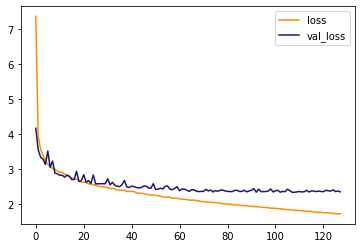

In [ ]:
loss_df_4_gridSearchCV = pd.DataFrame(losses_cnn_1_gridSearchCV.history)
loss_df_4_gridSearchCV.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_cnn_mse_gridSearchCV = model_7_gridSearchCV.evaluate(X_test_CNN, y_test, batch_size=1)
y_pred_cnn_1_gridSearchCV = model_7_gridSearchCV.predict(X_test_CNN)
y_pred_cnn_1_gridSearchCV = assign_negative_predictive_value(y_pred_cnn_1_gridSearchCV)

12720/12720 [==============================] - 25s 2ms/step - loss: 2.1946


In [ ]:
compa_k_mse_gridSearchCV.append(score_cnn_mse_gridSearchCV)

In [ ]:
print('mse: %f'%score_cnn_mse_gridSearchCV)

mse: 2.194587


In [ ]:
print(f"predicted response:\n{y_pred_cnn_1_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[6.24114132e+09]
 [4.09890175e+09]
 [6.53815079e+09]
 [5.93699217e+09]
 [3.85579181e+09]
 [8.65572071e+09]
 [3.43040943e+09]
 [7.56006670e+09]
 [5.50516367e+09]
 [7.91764355e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_cnn_1_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  64.0251572327044


### MAE

In [ ]:
model_7_gridSearchCV = CNN_Model(filters=grid.best_params_['filters'],kernel_size=grid.best_params_['kernel_size'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss='mean_absolute_error')
losses_cnn_2_gridSearchCV = model_7_gridSearchCV.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 1s 6ms/step - loss: 1.8654 - val_loss: 1.4635
Epoch 2/400
112/112 [==============================] - 1s 5ms/step - loss: 1.4449 - val_loss: 1.3753
Epoch 3/400
112/112 [==============================] - 1s 5ms/step - loss: 1.3506 - val_loss: 1.2968
Epoch 4/400
112/112 [==============================] - 1s 5ms/step - loss: 1.3067 - val_loss: 1.2685
Epoch 5/400
112/112 [==============================] - 1s 5ms/step - loss: 1.2866 - val_loss: 1.3697
Epoch 6/400
112/112 [==============================] - 1s 5ms/step - loss: 1.2454 - val_loss: 1.2059
Epoch 7/400
112/112 [==============================] - 1s 5ms/step - loss: 1.2274 - val_loss: 1.2150
Epoch 8/400
112/112 [==============================] - 1s 5ms/step - loss: 1.2268 - val_loss: 1.1804
Epoch 9/400
112/112 [==============================] - 1s 5ms/step - loss: 1.2061 - val_loss: 1.2223
Epoch 10/400
112/112 [==============================] - 1s 6ms/step - loss: 1.1841 - val_lo

#### Loss graph

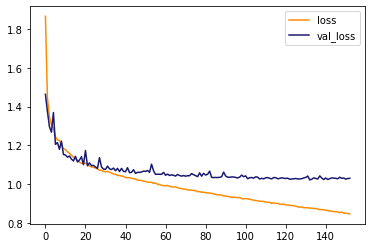

In [ ]:
loss_df_5_gridSearchCV = pd.DataFrame(losses_cnn_2_gridSearchCV.history)
loss_df_5_gridSearchCV.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_cnn_mae_gridSearchCV = model_7_gridSearchCV.evaluate(X_test_CNN, y_test, batch_size=1)
y_pred_cnn_2_gridSearchCV = model_7_gridSearchCV.predict(X_test_CNN)
y_pred_cnn_2_gridSearchCV = assign_negative_predictive_value(y_pred_cnn_2_gridSearchCV)

12720/12720 [==============================] - 24s 2ms/step - loss: 0.9991


In [ ]:
compa_k_mae_gridSearchCV.append(score_cnn_mae_gridSearchCV)

In [ ]:
print('mae: %f'%score_cnn_mae_gridSearchCV)

mae: 0.999080


In [ ]:
print(f"predicted response:\n{y_pred_cnn_2_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[5.79674101e+09]
 [4.78944969e+09]
 [6.49138737e+09]
 [4.73891640e+09]
 [3.98078752e+09]
 [9.45321178e+09]
 [3.44800544e+09]
 [7.67398024e+09]
 [4.81413221e+09]
 [8.01731300e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_cnn_2_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  65.68396226415094


### RMSE

In [ ]:
model_7_gridSearchCV = CNN_Model(filters=grid.best_params_['filters'],kernel_size=grid.best_params_['kernel_size'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss=root_mean_squared_error)
losses_cnn_3_gridSearchCV = model_7_gridSearchCV.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 2s 6ms/step - loss: 2.4890 - val_loss: 2.0836
Epoch 2/400
112/112 [==============================] - 1s 5ms/step - loss: 2.0012 - val_loss: 1.9192
Epoch 3/400
112/112 [==============================] - 1s 5ms/step - loss: 1.8889 - val_loss: 1.8674
Epoch 4/400
112/112 [==============================] - 0s 4ms/step - loss: 1.8450 - val_loss: 1.8243
Epoch 5/400
112/112 [==============================] - 0s 4ms/step - loss: 1.8170 - val_loss: 1.7688
Epoch 6/400
112/112 [==============================] - 1s 5ms/step - loss: 1.7813 - val_loss: 1.9350
Epoch 7/400
112/112 [==============================] - 1s 5ms/step - loss: 1.7593 - val_loss: 1.7375
Epoch 8/400
112/112 [==============================] - 1s 4ms/step - loss: 1.7434 - val_loss: 1.7188
Epoch 9/400
112/112 [==============================] - 1s 5ms/step - loss: 1.7253 - val_loss: 1.7002
Epoch 10/400
112/112 [==============================] - 1s 5ms/step - loss: 1.7095 - val_lo

#### Loss graph

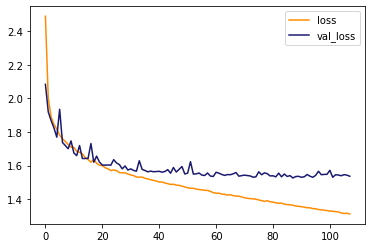

In [ ]:
loss_df_6_gridSearchCV = pd.DataFrame(losses_cnn_3_gridSearchCV.history)
loss_df_6_gridSearchCV.loc[:,['loss','val_loss']].plot(color = ['darkorange','midnightblue'])

#### Loss values

In [ ]:
score_cnn_rmse_gridSearchCV = model_7_gridSearchCV.evaluate(X_test_CNN, y_test, batch_size=1)
y_pred_cnn_3_gridSearchCV = model_7_gridSearchCV.predict(X_test_CNN)
y_pred_cnn_3_gridSearchCV = assign_negative_predictive_value(y_pred_cnn_3_gridSearchCV)

12720/12720 [==============================] - 26s 2ms/step - loss: 1.0201


In [ ]:
compa_k_rmse_gridSearchCV.append(score_cnn_rmse_gridSearchCV)

In [ ]:
print('rmse: %f'%score_cnn_rmse_gridSearchCV)

rmse: 1.020101


In [ ]:
print(f"predicted response:\n{y_pred_cnn_3_gridSearchCV[:10]*one_billion}")
print(f"actual:\n{y_test.iloc[0:10]*one_billion}")

predicted response:
[[6.14308834e+09]
 [4.34106684e+09]
 [6.14754152e+09]
 [5.75168085e+09]
 [3.89270353e+09]
 [8.91483212e+09]
 [3.65487003e+09]
 [7.82159519e+09]
 [5.68475580e+09]
 [6.10210991e+09]]
actual:
45253    6.500000e+09
22052    3.500000e+09
17716    7.000000e+09
47645    2.370000e+09
24952    3.780000e+09
14239    1.150000e+10
32696    3.200000e+09
594      5.700000e+09
14197    6.200000e+09
7532     9.500000e+09
Name: price, dtype: float64


In [ ]:
error, negative_integer = find_prediction_error_value(y_test, y_pred_cnn_3_gridSearchCV)
print("The number of negative prediction: ", len(negative_integer))
print("Percent correct prediction: ", (len(y_test) - len(error))/len(y_test)*100)

The number of negative prediction:  0
Percent correct prediction:  63.97012578616352


### R2

In [ ]:
model_7_gridSearchCV = CNN_Model(filters=grid.best_params_['filters'],kernel_size=grid.best_params_['kernel_size'], optimizer=grid.best_params_['optimizer'], activation=grid.best_params_['activation'], loss='mean_squared_error')
losses_cnn_4_gridSearchCV = model_7_gridSearchCV.fit(X_train_CNN, y_train, validation_data=(X_val_CNN, y_val), batch_size=256, epochs=400, callbacks=[earlyStop])

Epoch 1/400
112/112 [==============================] - 1s 6ms/step - loss: 7.0402 - val_loss: 4.2075
Epoch 2/400
112/112 [==============================] - 1s 5ms/step - loss: 3.9188 - val_loss: 4.3320
Epoch 3/400
112/112 [==============================] - 1s 5ms/step - loss: 3.4980 - val_loss: 3.2886
Epoch 4/400
112/112 [==============================] - 1s 5ms/step - loss: 3.3793 - val_loss: 3.1789
Epoch 5/400
112/112 [==============================] - 1s 5ms/step - loss: 3.2473 - val_loss: 3.0931
Epoch 6/400
112/112 [==============================] - 1s 5ms/step - loss: 3.1630 - val_loss: 3.2523
Epoch 7/400
112/112 [==============================] - 1s 5ms/step - loss: 3.0541 - val_loss: 2.9961
Epoch 8/400
112/112 [==============================] - 1s 5ms/step - loss: 3.0101 - val_loss: 3.0300
Epoch 9/400
112/112 [==============================] - 1s 5ms/step - loss: 2.9189 - val_loss: 2.8973
Epoch 10/400
112/112 [==============================] - 1s 6ms/step - loss: 2.8678 - val_lo

#### r2 values

In [ ]:
y_pred_cnn_4_gridSearchCV = model_7_gridSearchCV.predict(X_test_CNN)
y_pred_cnn_4_gridSearchCV = assign_negative_predictive_value(y_pred_cnn_4_gridSearchCV)
score_cnn_r2_gridSearchCV = r2_score(y_test, y_pred_cnn_4_gridSearchCV)

In [ ]:
compa_k_r2_gridSearchCV.append(score_cnn_r2_gridSearchCV)

In [ ]:
print('r2: %f'%score_cnn_r2_gridSearchCV)

r2: 0.775427


# COMPARISION

## Normal

### MSE

In [ ]:
print(compa_n_mse)

[4.467682067153811, 4.467686521651408, 9.071568618646282, 2.8805500981716237, 4.467693249478583]


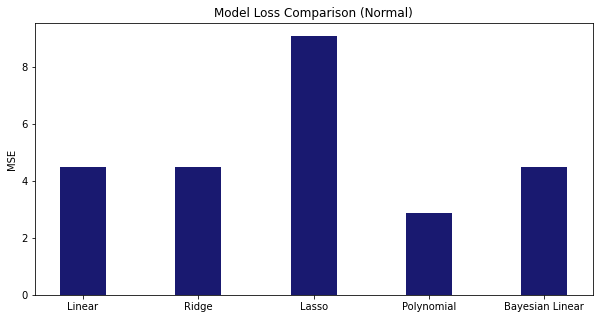

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_mse, width = 0.4, color = 'midnightblue')

plt.ylabel('MSE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### MAE

In [ ]:
print(compa_n_mae)

[1.5599390356075153, 1.5599132163230456, 2.284681583918462, 1.2000938155544876, 1.5598968592101532]


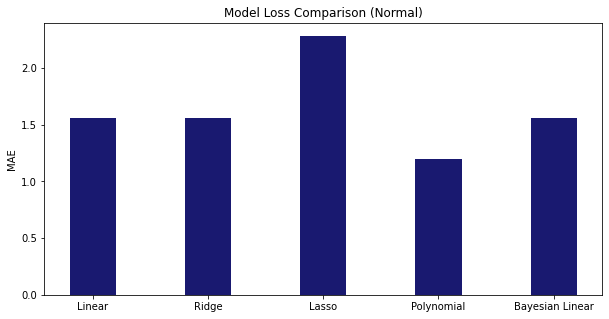

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_mae, width = 0.4, color = 'midnightblue')

plt.ylabel('MAE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### RMSE

In [ ]:
print(compa_n_rmse)

[2.113689207796125, 2.1136902615216373, 3.0119044836525415, 1.697218341337267, 2.1136918530094646]


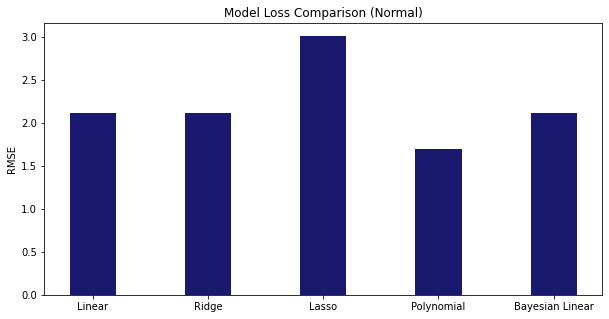

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_rmse, width = 0.4, color = 'midnightblue')

plt.ylabel('RMSE')
plt.title('Model Loss Comparison (Normal)')
plt.show()

### R2

In [ ]:
print(compa_n_r2)

[0.5404438710795993, 0.5404434128796557, 0.06687743331818752, 0.7036999427489796, 0.5404427208397643]


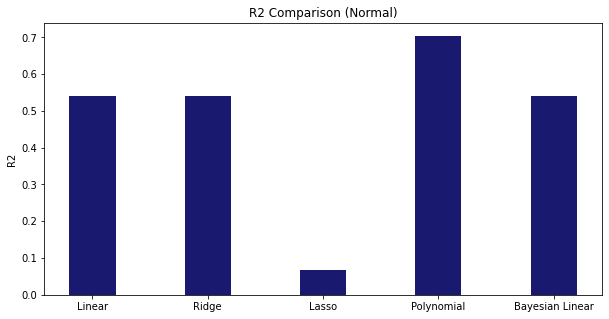

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels, compa_n_r2, width = 0.4, color = 'midnightblue')

plt.ylabel('R2')
plt.title('R2 Comparison (Normal)')
plt.show()

## K-Fold

### MSE

In [ ]:
print(compa_k_mse)

[2.6679296493530273, 4.552014520467494, 4.552009463879321, 9.324592121639643, 2.954810893808507, 4.552010568731281, 2.289259672164917]


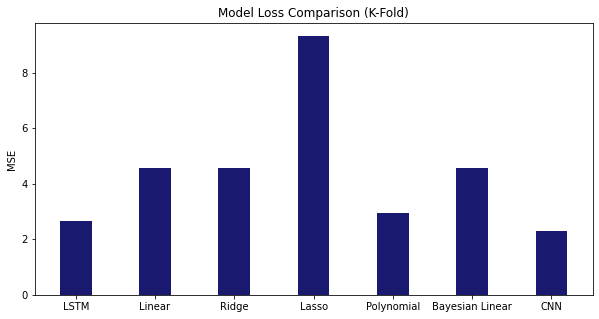

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_mse, width = 0.4, color = 'midnightblue')

plt.ylabel('MSE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### MAE

In [ ]:
print(compa_k_mae)

[1.1248817443847656, 1.5675303908191478, 1.567519038907501, 2.3092837785629188, 1.205676216004035, 1.567512881316243, 1.0159289836883545]


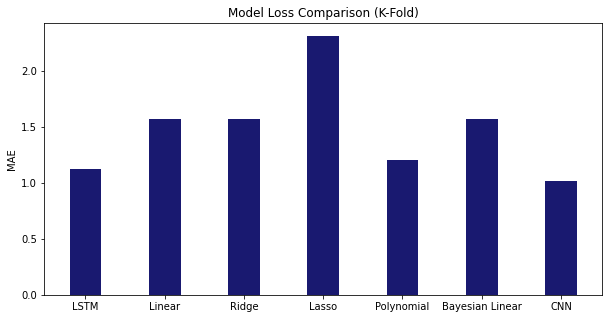

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_mae, width = 0.4, color = 'midnightblue')

plt.ylabel('MAE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### RMSE

In [ ]:
print(compa_k_rmse)

[1.1359978914260864, 2.1335450593946907, 2.1335438743741175, 3.053619511602525, 1.718956338540484, 2.133544133298227, 1.0256054401397705]


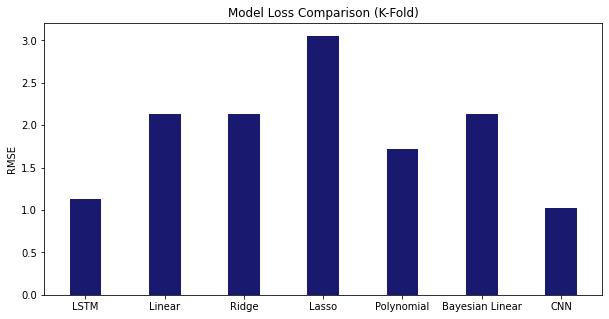

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_rmse, width = 0.4, color = 'midnightblue')

plt.ylabel('RMSE')
plt.title('Model Loss Comparison (K-Fold)')
plt.show()

### R2

In [ ]:
print(compa_k_r2)

[0.7411857228519696, 0.5426363157599838, 0.5426368556380845, 0.06335520287085998, 0.7031374132530992, 0.5426367605055474, 0.7726658706686471]


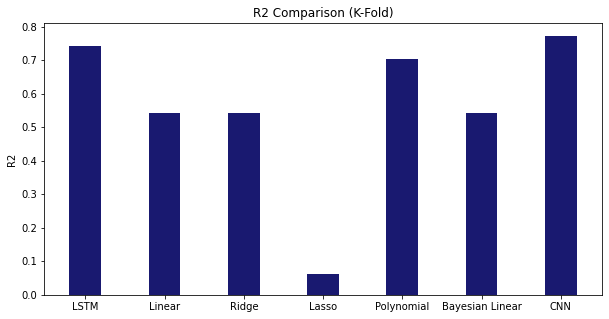

In [ ]:
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(labels_kfold, compa_k_r2, width = 0.4, color = 'midnightblue')

plt.ylabel('R2')
plt.title('R2 Comparison (K-Fold)')
plt.show()

## Using GridSearchCV

### MSE

In [ ]:
print(compa_k_mse_gridSearchCV)

[2.393171548843384, 4.552102258902302, 5.598442072617386, 2.5859334715890783, 2.1945865154266357]


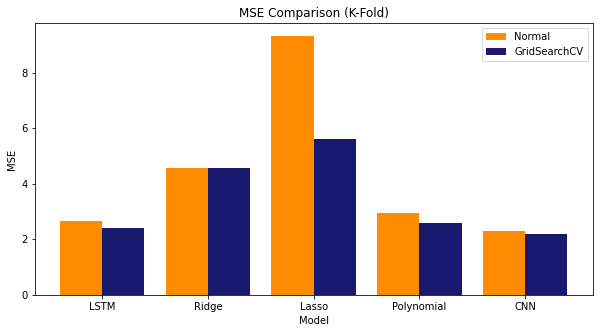

In [ ]:
fig = plt.figure(figsize = (10, 5))
width = 0.4
index = np.arange(len(labels_gridSearchCV))
compa_k_mse_not_use_gridsearchCV = [compa_k_mse[0],compa_k_mse[2],compa_k_mse[3],compa_k_mse[4],compa_k_mse[6]]
plt.bar(index,compa_k_mse_not_use_gridsearchCV,width,label='Normal', color = 'darkorange')
plt.bar(index+width,compa_k_mse_gridSearchCV,width,label='GridSearchCV', color = 'midnightblue')
plt.ylabel('MSE')
plt.xlabel('Model')
plt.xticks(index+0.2,labels_gridSearchCV)
plt.title('MSE Comparison (K-Fold)')
plt.legend(loc='best')
plt.show()

### MAE

In [ ]:
print(compa_k_mae_gridSearchCV)

[1.0417943000793457, 1.5676419257131573, 1.7065390302483192, 1.1148497034297997, 0.9990803003311157]


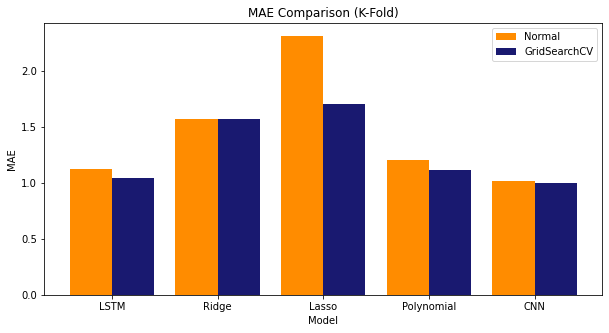

In [ ]:
fig = plt.figure(figsize = (10, 5))
width = 0.4
index = np.arange(len(labels_gridSearchCV))
compa_k_mae_not_use_gridsearchCV = [compa_k_mae[0],compa_k_mae[2],compa_k_mae[3],compa_k_mae[4],compa_k_mae[6]]
plt.bar(index,compa_k_mae_not_use_gridsearchCV,width,label='Normal', color = 'darkorange')
plt.bar(index+width,compa_k_mae_gridSearchCV,width,label='GridSearchCV', color = 'midnightblue')
plt.ylabel('MAE')
plt.xlabel('Model')
plt.xticks(index+0.2,labels_gridSearchCV)
plt.title('MAE Comparison (K-Fold)')
plt.legend(loc='best')
plt.show()

### RMSE

In [ ]:
print(compa_k_rmse_gridSearchCV)

[1.0581798553466797, 2.1335656209505958, 2.36610271810363, 1.6080837887339945, 1.0201010704040527]


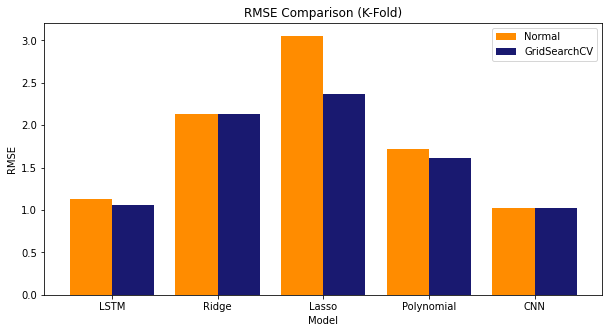

In [ ]:
fig = plt.figure(figsize = (10, 5))
width = 0.4
index = np.arange(len(labels_gridSearchCV))
compa_k_rmse_not_use_gridsearchCV = [compa_k_rmse[0],compa_k_rmse[2],compa_k_rmse[3],compa_k_rmse[4],compa_k_rmse[6]]
plt.bar(index,compa_k_rmse_not_use_gridsearchCV,width,label='Normal', color = 'darkorange')
plt.bar(index+width,compa_k_rmse_gridSearchCV,width,label='GridSearchCV', color = 'midnightblue')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(index+0.2,labels_gridSearchCV)
plt.title('RMSE Comparison (K-Fold)')
plt.legend(loc='best')
plt.show()

### R2

In [ ]:
print(compa_k_r2_gridSearchCV)

[0.7600832668014592, 0.5426274282184729, 0.43761984123590913, 0.7401139183047807, 0.7754268879731059]


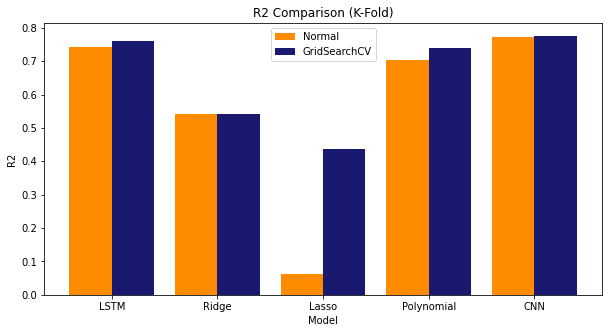

In [ ]:
fig = plt.figure(figsize = (10, 5))
width = 0.4
index = np.arange(len(labels_gridSearchCV))
compa_k_r2_not_use_gridsearchCV = [compa_k_r2[0],compa_k_r2[2],compa_k_r2[3],compa_k_r2[4],compa_k_r2[6]]
plt.bar(index,compa_k_r2_not_use_gridsearchCV,width,label='Normal', color = 'darkorange')
plt.bar(index+width,compa_k_r2_gridSearchCV,width,label='GridSearchCV', color = 'midnightblue')
plt.ylabel('R2')
plt.xlabel('Model')
plt.xticks(index+0.2,labels_gridSearchCV)
plt.title('R2 Comparison (K-Fold)')
plt.legend(loc='best')
plt.show()